In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [2]:
import logging
import hydra
import torch
from hydra import compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
from model.sam2.sam2_image_predictor import SAM2ImagePredictor

hydra.initialize(version_base="1.1", config_path="model/configs")
cfg = compose(config_name="sam2.1_hiera_t.yaml")
OmegaConf.resolve(cfg)
model = instantiate(cfg.model, _recursive_=True)


def _load_checkpoint(model, ckpt_path):
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cpu", weights_only=True)["model"]
        missing_keys, unexpected_keys = model.load_state_dict(sd, strict=False)
        logging.info("Loaded checkpoint sucessfully")
    return missing_keys, unexpected_keys


print("Finish Load Model")
missing_keys, unexpected_keys = _load_checkpoint(
    model, "/home/ljl/CodeStore/SAM-IRSTD/checkpoints/sam2.1_hiera_tiny.pt"
)
predictor = SAM2ImagePredictor(model)

Finish Load Model


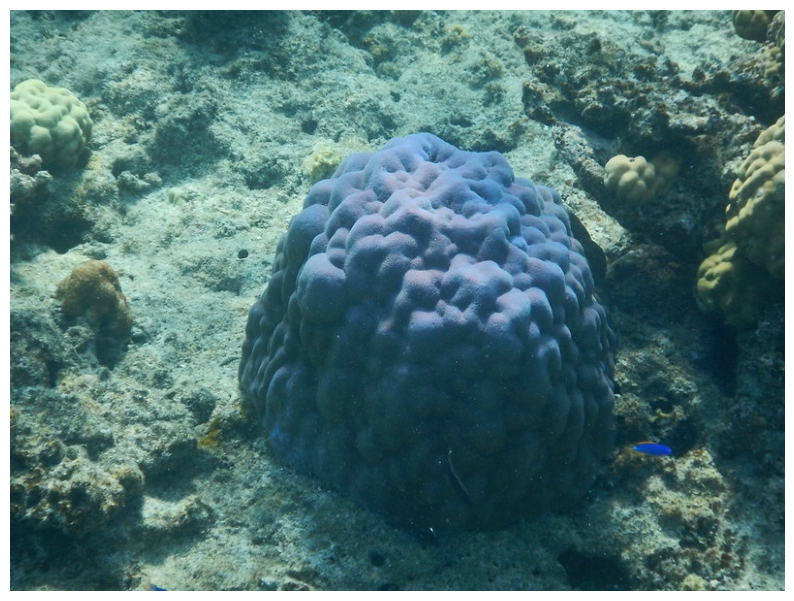

In [3]:
image = Image.open('/data/ljl/Dataset/COD10K-v3/Train/Image/COD10K-NonCAM-5-Background-2-Ocean-3247.jpg')
image = np.array(image.convert("RGB"))

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

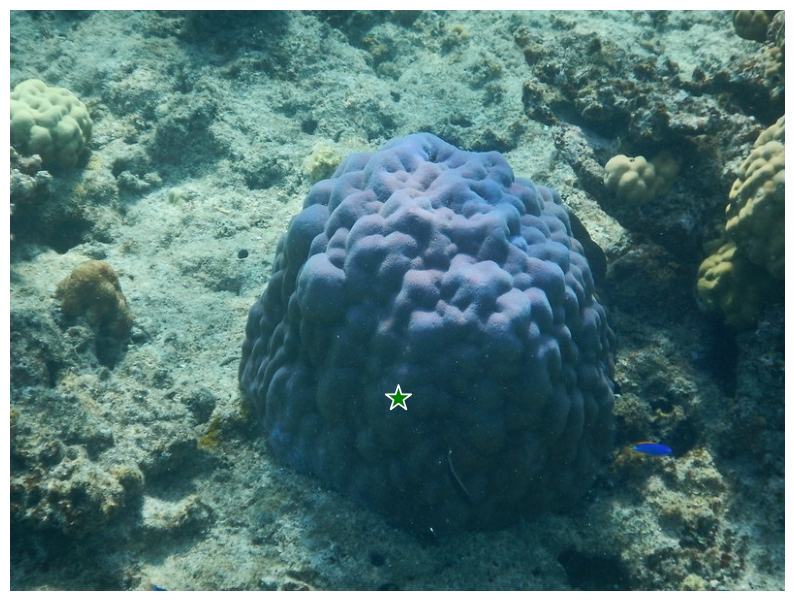

In [4]:
input_point = np.array([[400, 400]])
input_label = np.array([1])
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()  

In [5]:
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

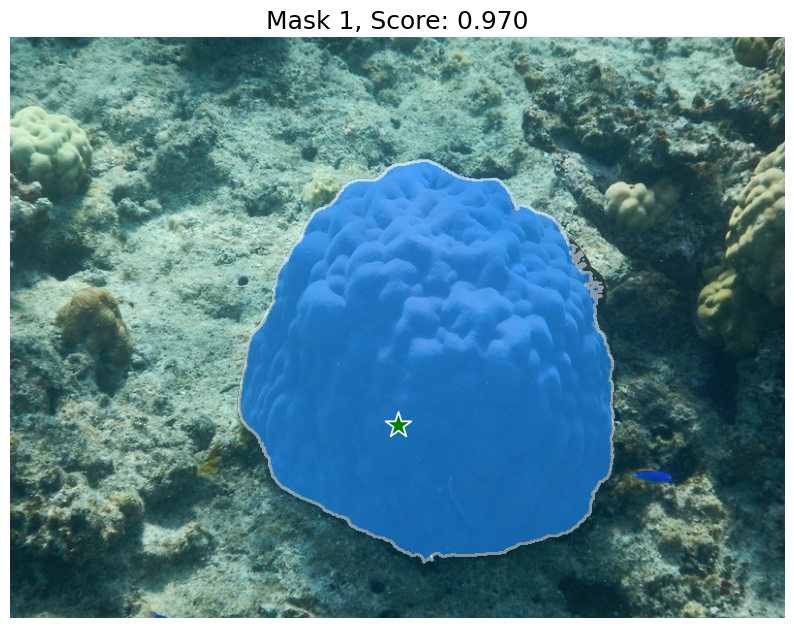

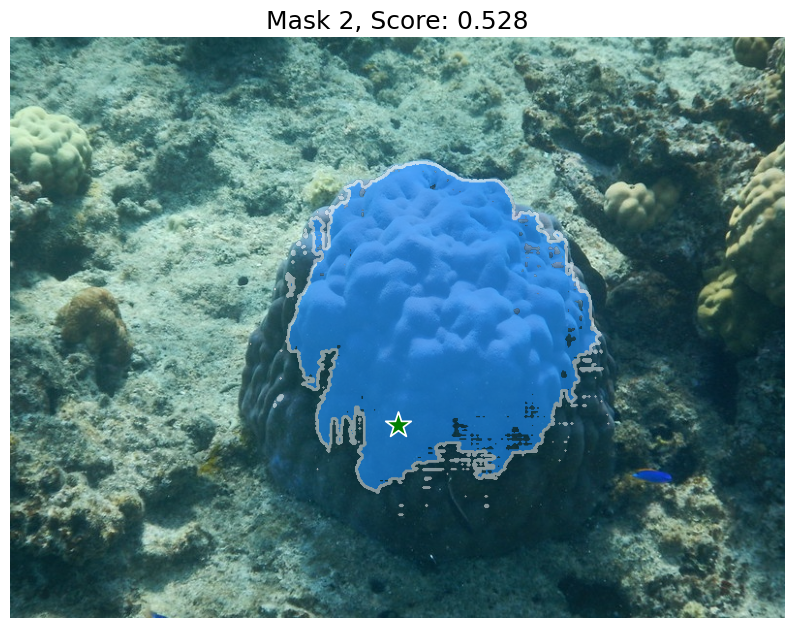

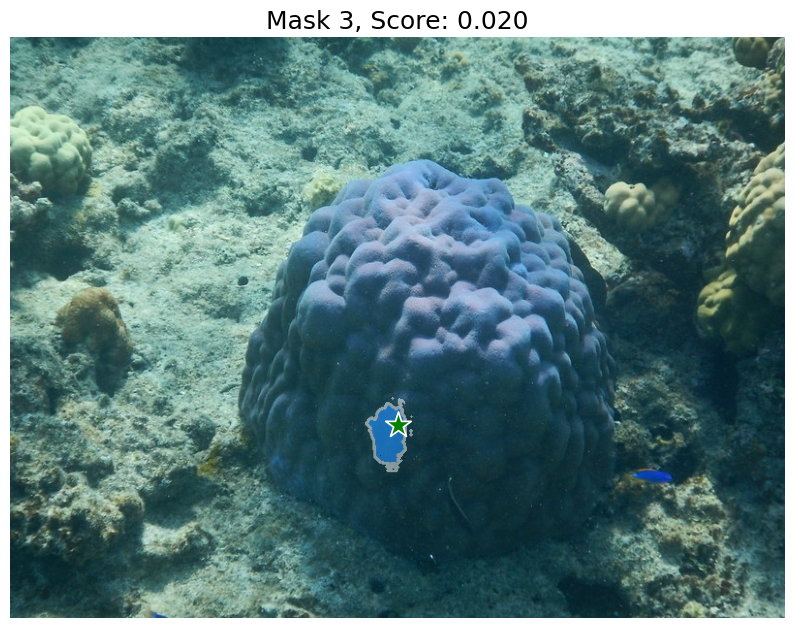

In [6]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

In [ ]:
predictor.set_image_batch([image, image])
masks, scores, logits = predictor.predict_batch(
    point_coords_batch=[input_point, input_point],
    point_labels_batch=[input_label, input_label],
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[0][sorted_ind]
scores = scores[0][sorted_ind]
logits = logits[0][sorted_ind]